In [2]:
%matplotlib inline
import sys
sys.path.insert( 0, '/Users/alam/open_source/yellowbrick/')
print( sys.path )

['/Users/alam/open_source/yellowbrick/', '', '/Users/alam/anaconda3/lib/python36.zip', '/Users/alam/anaconda3/lib/python3.6', '/Users/alam/anaconda3/lib/python3.6/lib-dynload', '/Users/alam/anaconda3/lib/python3.6/site-packages', '/Users/alam/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/alam/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/alam/.ipython']


In [3]:
# %load ../../../yellowbrick/yellowbrick/features/jointplot.py

# yellowbrick.features.jointplot
# Implementations of joint plots for univariate and bivariate analysis.
#
# Author:   Prema Damodaran Roman
# Created:  Mon Apr 10 21:00:54 2017 -0400
#
# Copyright (C) 2017 District Data Labs
# For license information, see LICENSE.txt
#
# ID: jointplot.py [7f47800] pdamodaran@users.noreply.github.com $

##########################################################################
## Imports
##########################################################################

import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from yellowbrick.features.base import FeatureVisualizer
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.bestfit import draw_best_fit
from yellowbrick.utils import is_dataframe

##########################################################################
## Joint Plot Visualizer
##########################################################################


class JointPlotVisualizer(FeatureVisualizer):
    """
    JointPlotVisualizer allows for a simultaneous visualization of the relationship
    between two variables and the distrbution of each individual variable.  The
    relationship is plotted along the joint axis and univariate distributions
    are plotted on top of the x axis and to the right of the y axis.

    Parameters
    ----------
    ax: matplotlib Axes, default: None
        This is inherited from FeatureVisualizer but is defined within
        JointPlotVisualizer since there are three axes objects.

    feature: string, default: None
        The name of the X variable
        If a DataFrame is passed to fit and feature is None, feature
        is selected as the column of the DataFrame.  There must be only
        one column in the DataFrame.

    target: string, default: None
        The name of the Y variable
        If target is None and a y value is passed to fit then the target
        is selected from the target vector.

    joint_plot: one of {'scatter', 'hex'}, default: 'scatter'
        The type of plot to render in the joint axis
        Currently, the choices are scatter and hex.
        Use scatter for small datasets and hex for large datasets

    joint_args: dict, default: None
        Keyword arguments used for customizing the joint plot:

        =============   ==================================================================
        Property        Description
        -------------   ------------------------------------------------------------------
        alpha           transparency
        facecolor       background color of the joint axis
        aspect          aspect ratio
        fit             used if scatter is selected for joint_plot to draw a
                        best fit line - values can be True or False.
                        Uses ``Yellowbrick.bestfit``
        estimator       used if scatter is selected for joint_plot to determine
                        the type of best fit line to use.  Refer to
                        Yellowbrick.bestfit for types of estimators that can be used.
        x_bins          used if hex is selected to set the number of bins for the x value
        y_bins          used if hex is selected to set the number of bins for the y value
        cmap            string or matplotlib cmap to colorize lines
                        Use either color to colorize the lines on a per class basis or
                        colormap to color them on a continuous scale.
        =============   ==================================================================

    xy_plot: one of {'hist'}, default: 'hist'
        The type of plot to render along the x and y axes
        Currently, the choice is hist

    xy_args: dict, default: None
        Keyword arguments used for customizing the x and y plots:

        ==============  =====================================================
        Property        Description
        --------------  -----------------------------------------------------
        alpha           transparency
        facecolor_x     background color of the x axis
        facecolor_y     background color of the y axis
        bins            used to set up the number of bins for the hist plot
        histcolor_x     used to set the color for the histogram on the x axis
        histcolor_y     used to set the color for the histogram on the y axis
        ==============  =====================================================

    size: float, default: 600
        Size of each side of the figure in pixels

    ratio: float, default: 5
        Ratio of joint axis size to the x and y axes height

    space: float, default: 0.2
        Space between the joint axis and the x and y axes

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------

    >>> visualizer = JointPlotVisualizer()
    >>> visualizer.fit(X,y)
    >>> visualizer.poof()

    Notes
    -----
    These parameters can be influenced later on in the visualization
    process, but can and should be set as early as possible.
    """

    def __init__(self, ax=None, feature=None, target=None,
                 joint_plot='scatter', joint_args=None,
                 xy_plot='hist', xy_args=None,
                 size=600, ratio=5, space=.2, **kwargs):

        # Check matplotlib version - needs to be version 2.0.0 or greater.
        mpl_vers_maj = int(mpl.__version__.split(".")[0])
        if mpl_vers_maj < 2:
            warnings.warn((
                "{} requires matplotlib major version 2 or greater. "
                "Please upgrade."
            ).format(self.__class__.__name__))

        super(JointPlotVisualizer, self).__init__(ax, **kwargs)

        self.feature = feature
        self.target = target
        self.joint_plot = joint_plot
        self.joint_args = joint_args
        self.xy_plot = xy_plot
        self.xy_args = xy_args
        self.size = (size, size)
        self.ratio = ratio
        self.space = space

    def fit(self, X, y, **kwargs):
        """
        Sets up the X and y variables for the jointplot
        and checks to ensure that X and y are of the
        correct data type

        Fit calls draw

        Parameters
        ----------

        X : ndarray or DataFrame of shape n x 1
            A matrix of n instances with 1 feature

        y : ndarray or Series of length n
            An array or series of the target value

        kwargs: dict
            keyword arguments passed to Scikit-Learn API.
        """

        #throw an error if X has more than 1 column
        if is_dataframe(X):
            nrows, ncols = X.shape

            if ncols > 1:
                raise YellowbrickValueError((
                    "X needs to be an ndarray or DataFrame with one feature, "
                    "please select one feature from the DataFrame"
                ))

        #throw an error is y is None
        if y is None:
            raise YellowbrickValueError((
                "Joint plots are useful for classification and regression "
                "problems, which require a target variable"
            ))


        # Handle the feature name if it is None.
        if self.feature is None:

            # If X is a data frame, get the columns off it.
            if is_dataframe(X):
                self.feature = X.columns

            else:
                self.feature = ['x']

        # Handle the target name if it is None.
        if self.target is None:
            self.target = ['y']

        self.draw(X, y, **kwargs)
        return self

    def draw(self, X, y, **kwargs):
        """
        Sets up the layout for the joint plot draw calls ``draw_joint`` and
        ``draw_xy`` to render the visualizations.
        """
        fig = plt.gcf()
        gs = plt.GridSpec(self.ratio + 1, self.ratio + 1)

        #Set up the 3 axes objects
        joint_ax = fig.add_subplot(gs[1:, :-1])
        x_ax = fig.add_subplot(gs[0, :-1], sharex=joint_ax)
        y_ax = fig.add_subplot(gs[1:, -1], sharey=joint_ax)

        fig.tight_layout()
        fig.subplots_adjust(hspace=self.space, wspace=self.space)

        self.fig = fig
        self.joint_ax = joint_ax
        self.x_ax = x_ax
        self.y_ax = y_ax

        self.draw_joint(X, y, **kwargs)
        self.draw_xy(X, y, **kwargs)

    def draw_joint(self, X, y, **kwargs):
        """
        Draws the visualization for the joint axis.
        """

        if self.joint_args is None:
            self.joint_args = {}

        self.joint_args.setdefault("alpha", 0.4)
        facecolor = self.joint_args.pop("facecolor", "#dddddd")
        self.joint_ax.set_facecolor(facecolor)

        if self.joint_plot == "scatter":
            aspect = self.joint_args.pop("aspect", "auto")
            self.joint_ax.set_aspect(aspect)
            self.joint_ax.scatter(X, y, **self.joint_args)

            fit = self.joint_args.pop("fit", True)
            if fit:
                estimator = self.joint_args.pop("estimator", "linear")
                draw_best_fit(X, y, self.joint_ax, estimator)

        elif self.joint_plot == "hex":
            x_bins = self.joint_args.pop("x_bins", 50)
            y_bins = self.joint_args.pop("y_bins", 50)
            colormap = self.joint_args.pop("cmap", 'Blues')
            gridsize = int(np.mean([x_bins, y_bins]))

            xmin = X.min()
            xmax = X.max()
            ymin = y.min()
            ymax = y.max()

            self.joint_ax.hexbin(X, y,
                gridsize=gridsize, cmap=colormap, mincnt=1, **self.joint_args
            )
            self.joint_ax.axis([xmin, xmax, ymin, ymax])

    def draw_xy(self, X, y, **kwargs):
        """
        Draws the visualization for the x and y axes
        """

        if self.xy_args is None:
            self.xy_args = {}

        facecolor_x = self.xy_args.pop("facecolor_x", "#dddddd")
        self.x_ax.set_facecolor(facecolor_x)
        facecolor_y = self.xy_args.pop("facecolor_y", "#dddddd")
        self.y_ax.set_facecolor(facecolor_y)


        if self.xy_plot == "hist":
            hist_bins = self.xy_args.pop("bins", 50)
            self.xy_args.setdefault("alpha", 0.4)
            histcolor_x = self.xy_args.pop("histcolor_x", "#6897bb")
            self.x_ax.set_facecolor(facecolor_x)
            histcolor_y = self.xy_args.pop("histcolor_y", "#6897bb")
            self.y_ax.set_facecolor(facecolor_y)
            self.x_ax.hist(X, bins=hist_bins, color=histcolor_x, **self.xy_args)
            self.y_ax.hist(y, bins=hist_bins, color=histcolor_y,
                              orientation='horizontal', **self.xy_args)

    def poof(self, **kwargs):
        """
        Creates the labels for the feature and target variables
        """

        self.joint_ax.set_xlabel(self.feature)
        self.joint_ax.set_ylabel(self.target)
        self.finalize(**kwargs)

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.
        """

        plt.setp(self.x_ax.get_xticklabels(), visible=False)
        plt.setp(self.y_ax.get_yticklabels(), visible=False)

        plt.setp(self.x_ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(self.x_ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(self.y_ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(self.y_ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(self.x_ax.get_yticklabels(), visible=False)
        plt.setp(self.y_ax.get_xticklabels(), visible=False)
        self.x_ax.yaxis.grid(False)
        self.y_ax.xaxis.grid(False)
        self.fig.suptitle("Joint Plot of {} vs {}"
                        .format(self.feature, self.target), y=1.05)


[4.9 3.  1.4 0.2] [4.7 3.2 1.3 0.2]


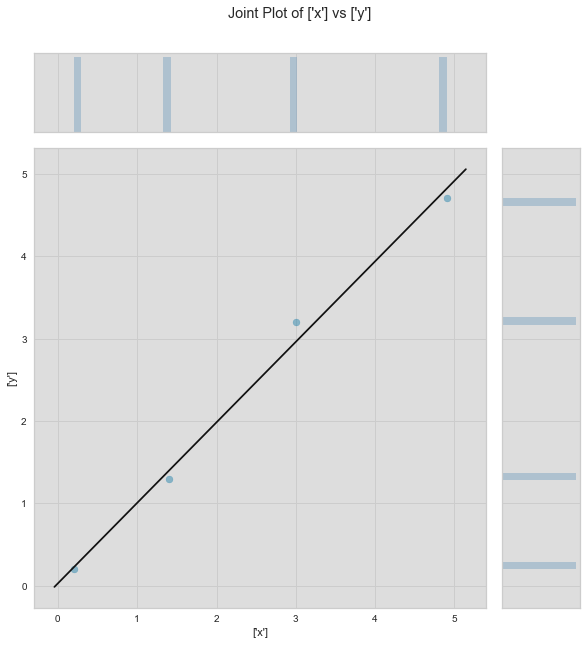

In [13]:
from sklearn import datasets

iris = datasets.load_iris()

# scores = cross_val_score(clf, iris.data, iris.target, cv=5)
X = iris.data[1]
y = iris.data[2]
print( X, y)

visualizer = JointPlotVisualizer()
visualizer.fit(X,y)
g = visualizer.poof()